In [188]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test / 255.).astype(np.float32)

# Split training data into train and validation sets
val_split = 0.2
num_val_samples = int(cifar10_x_train.shape[0] * val_split)

cifar10_x_val = cifar10_x_train[:num_val_samples]
cifar10_y_val = cifar10_y_train[:num_val_samples]

cifar10_x_train = cifar10_x_train[num_val_samples:]
cifar10_y_train = cifar10_y_train[num_val_samples:]

# Separate data into two groups for training
cond_1_train = cifar10_y_train[:, 0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1_train]
cifar10_y_train_1 = cifar10_y_train[cond_1_train]

cond_2_train = cifar10_y_train[:, 0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2_train]
cifar10_y_train_2 = cifar10_y_train[cond_2_train]

# Separate validation data into two groups
cond_1_val = cifar10_y_val[:, 0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:, 0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

# Separate test data into two groups
cond_1_test = cifar10_y_test[:, 0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:, 0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]






first: bird, second = horse


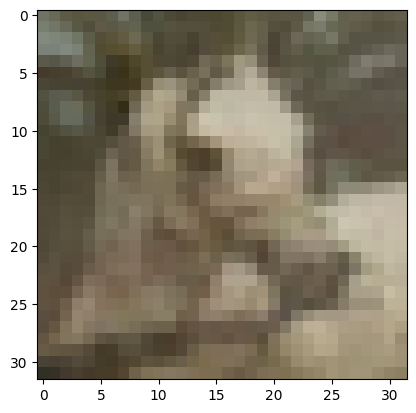

In [189]:
def datagenerator(X1, X2, Y1, Y2, batchsize):
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
    Y2_cat = tf.keras.utils.to_categorical(Y2 - 5, num_classes=5)

    while True:
        num1 = np.random.randint(0, size1, batchsize)
        num2 = np.random.randint(0, size2, batchsize)
        x_data = (X1[num1] + X2[num2]) / 2.0
        y_data = (Y1_cat[num1], Y2_cat[num2])
        yield x_data, y_data

datagen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 1)
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])], classes[np.argmax(y[1][0]) + 5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

In [190]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Resizing(128, 128),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(1.0),
    layers.RandomZoom(1.0),
    layers.RandomContrast(0.5)
])

In [191]:
def enhanced_cnn_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)  # Apply augmentation

    # First convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    """
    # Fully connected layers for output 1
    fc1_output1 = layers.Dense(1024, activation='relu')(x)
    fc1_output1 = layers.Dropout(0.5)(fc1_output1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2
    fc1_output2 = layers.Dense(1024, activation='relu')(x)
    fc1_output2 = layers.Dropout(0.5)(fc1_output2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)
    """
    # Fully connected layers for output 1 with Leaky ReLU
    fc1_output1 = layers.Dense(1024, activation=None)(x)
    fc1_output1 = layers.LeakyReLU(alpha=0.1)(fc1_output1)
    fc1_output1 = layers.Dropout(0.3)(fc1_output1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2 with Leaky ReLU
    fc1_output2 = layers.Dense(1024, activation=None)(x)
    fc1_output2 = layers.LeakyReLU(alpha=0.1)(fc1_output2)
    fc1_output2 = layers.Dropout(0.3)(fc1_output2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model



In [192]:

class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        smooth_positives = 1.0 - self.smoothing
        smooth_negatives = self.smoothing / num_classes
        y_true_smoothed = y_true * smooth_positives + smooth_negatives
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true_smoothed, y_pred))



In [193]:
# Define learning rate scheduler
initial_lr = 0.001
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps= 5 * 500,  # Assuming 10 epochs
    decay_rate=0.7,
    staircase=True
)

In [194]:
# Define the optimizer with layer-specific learning rates
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, lr_multipliers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr_multipliers = lr_multipliers

    def _resource_apply_dense(self, grad, var, apply_state=None):
        multiplier = self.lr_multipliers.get(var.name, 1.0)
        scaled_lr = self._get_hyper("learning_rate") * multiplier
        self._set_hyper("learning_rate", scaled_lr)
        return super()._resource_apply_dense(grad, var, apply_state)

# Define learning rate multipliers
lr_multipliers = {
    'conv2d/kernel:0': 1e-5,  # Early layers
    'conv2d_1/kernel:0': 1e-5,
    'conv2d_2/kernel:0': 1e-4,  # Middle layers
    'conv2d_3/kernel:0': 1e-4,
    'dense/kernel:0': 1e-3,  # Final dense layers
    'dense_1/kernel:0': 1e-3
}

# Compile the model with a custom optimizer
custom_optimizer = CustomAdam(
    learning_rate=scheduler,
    lr_multipliers=lr_multipliers
)

In [195]:
model = enhanced_cnn_model()
model.compile(
    optimizer=custom_optimizer,
    loss={'output1': LabelSmoothingLoss(smoothing=0.1), 'output2': LabelSmoothingLoss(smoothing=0.1)},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)

"""
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
    loss={'output1': LabelSmoothingLoss(smoothing=0.1), 'output2': LabelSmoothingLoss(smoothing=0.1)},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)
"""

"""
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
"""

train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 64)
val_gen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, 64)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=50,
    validation_data=val_gen,
    validation_steps=100
)



Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 3.4460 - output1_accuracy: 0.3777 - output1_loss: 1.6708 - output2_accuracy: 0.4244 - output2_loss: 1.7752 - val_loss: 5.0759 - val_output1_accuracy: 0.3197 - val_output1_loss: 2.0187 - val_output2_accuracy: 0.3834 - val_output2_loss: 3.0572
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4521 - output1_accuracy: 0.5097 - output1_loss: 1.2912 - output2_accuracy: 0.5942 - output2_loss: 1.1609 - val_loss: 2.6518 - val_output1_accuracy: 0.4395 - val_output1_loss: 1.4312 - val_output2_accuracy: 0.5727 - val_output2_loss: 1.2207
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2726 - output1_accuracy: 0.5599 - output1_loss: 1.2130 - output2_accuracy: 0.6579 - output2_loss: 1.0596 - val_loss: 2.9738 - val_output1_accuracy: 0.4506 - val_output1_loss: 1.4246 - val_output2_accuracy: 0.4238 - val_output2_loss: 1.5493
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1763 - output1_accuracy: 0.5880

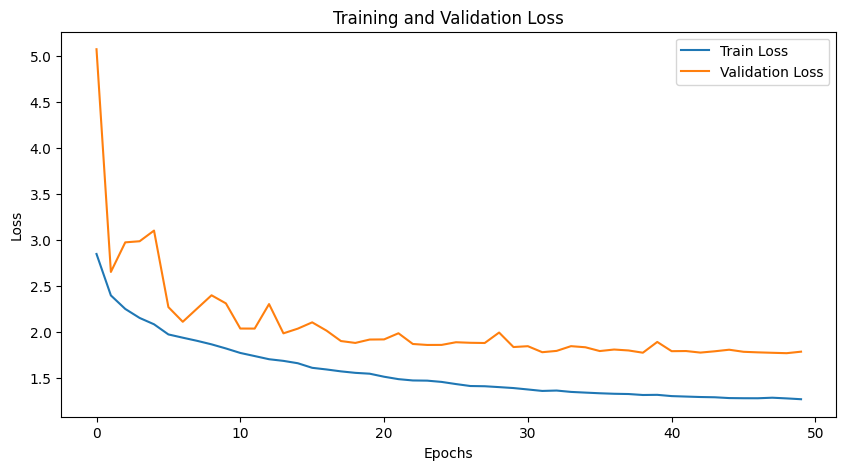

In [196]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [197]:
# Save the model weights
model.save_weights("enhanced_cnn_best.weights.h5")

In [198]:
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean accuracy = 0.756405
Standard deviation = 0.0028091324283486875
